# 基于alphalens的alpha因子分析

Alphalens旨在帮助分析和评估"阿尔法因子"的表现,阿尔法因子是用于预测金融工具未来价格走势的数据转换指标。阿尔法因子通常以每只资产每天的单一数值形式存在,因子值的绝对大小并不重要,重要的是相对其他资产的大小排序。我们通过考虑每日因子值的相对大小来评估阿尔法因子的预测能力。

需要注意的是,阿尔法因子和最终的交易策略是有区别的。交易策略使用单个或多个阿尔法因子的组合作为信号源,并根据这些信号结合实际的交易执行、风险管理等模块生成实际的交易指令。换言之,交易策略将预测转化为实际的投资操作和获利。而阿尔法因子仅仅关注预测未来价格走势这一环节。由于关注的范围不同,评估阿尔法因子和评估交易策略的方法也不尽相同。

Alphalens专注于评估阿尔法因子的预测表现,不涉及对实际交易成本、头寸规模限制或投资组合构建等实施层面的分析。对于需要评估完整交易策略表现的用户,可以使用pyfolio这一专门的库。


* beta因子与alpha因子区别

β因子和α因子是资产定价模型中两个重要的概念,它们反映了不同的风险来源,主要区别如下:

1. 定义不同
α因子反映个别资产相对大盘超额的预期收益能力,代表选股能力。
β因子则衡量个别资产受整体市场波动影响的程度,反映系统性风险。

2. 性质不同  
α因子是主动投资的体现,投资经理通过选择有α的资产组合来创造超额收益。
β因子是被动投资的体现,反映了无法通过分散化规避的系统性风险。

3. 可控性不同
α因子在理论上是可以通过主动选股被创造和捕捉的。
β因子则是外生的系统性风险,投资经理无法控制。

4. 持续性不同
一般认为α因子的持续性较差,需要不断发掘新的α机会。
而β因子具有一定的持续性和稳定性。

5. 定价影响不同
资产定价模型认为,只有β因子才会被市场合理定价并获得风险补偿。
α因子反映了市场无效率,持续存在α是违背有效市场理论的。

总之,α因子和β因子分别反映了投资组合的主动和被动风险来源,对投资组合管理和资产定价具有重要意义。


* 本课件很多内容由claude.ai生成，特此感谢！

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns

## alphalens安装

原版

https://github.com/quantopian/alphalens/tree/master

另一个版本的alphalens

https://alphalens.ml4trading.io/index.html

In [ ]:
#! pip install alphalens-reloaded -i https://mirrors.aliyun.com/pypi/simple
#! pip install seaborn -i https://mirrors.aliyun.com/pypi/simple

In [2]:
import alphalens
alphalens.__version__

'0.4.3'

## 参考链接

主要代码来源：

https://alphalens.ml4trading.io/notebooks/overview.html

非常好的外网文章翻译：

https://zhuanlan.zhihu.com/p/546143901

## 数据准备与处理

* 因子数据

* 价格数据

pd.to_datetime((stock_daily0["交易日期"].astype("str")), utc=True)

pivot(index="",columns="",values="").dropna(axis=1)

.isin(stock_close.columns)

set_index  sort_index()

In [49]:
help(alphalens.utils.get_clean_factor_and_forward_returns)

Help on function get_clean_factor_and_forward_returns in module alphalens.utils:

get_clean_factor_and_forward_returns(factor, prices, groupby=None, binning_by_group=False, quantiles=5, bins=None, periods=(1, 5, 10), filter_zscore=20, groupby_labels=None, max_loss=0.35, zero_aware=False, cumulative_returns=True)
    Formats the factor data, pricing data, and group mappings into a DataFrame
    that contains aligned MultiIndex indices of timestamp and asset. The
    returned data will be formatted to be suitable for Alphalens functions.
    
    It is safe to skip a call to this function and still make use of Alphalens
    functionalities as long as the factor data conforms to the format returned
    from get_clean_factor_and_forward_returns and documented here
    
    Parameters
    ----------
    factor : pd.Series - MultiIndex
        A MultiIndex Series indexed by timestamp (level 0) and asset
        (level 1), containing the values for a single alpha factor.
        ::
          

In [3]:
# 此数据来自淘宝
conn=sqlite3.connect(r'I:\量化金融\stock_2018.db')
#获取数据库中的表
c = conn.cursor()
c.execute("select name from sqlite_master where type='table'")
tab_name=c.fetchall()
tab_name

[('xjllb',), ('zcfzb',), ('lrb',), ('cwzbsj',), ('stock_daily',)]

In [4]:
stock_daily0=pd.read_sql("select * from stock_daily where 交易日期>'20200101' and 交易日期<'20210101' ",con=conn)
stock_daily0.head()

,index,交易日期,股票代码,股票简称,开盘价,最高价,最低价,收盘价,成交量(手),成交额(千元),...,市盈率(动态),市净率,市销率,市销率(TTM),股息率(%),股息率(TTM)(%),总股本(万股),流通股本(万股),总市值(万元),流通市值(万元)
0,6807,20200102,000002.SZ,万科A,4867.9136,4986.6432,4824.8741,4832.2947,1012130.40,3342373.870,...,NaN,2.2000,1.2362,1.0649,3.2098,3.2098,1.130214e+06,971517.0043,3.679978e+07,3.163259e+07
1,6808,20200103,000002.SZ,万科A,4854.5565,4869.3977,4716.5334,4756.6046,805536.29,2584309.903,...,14.89,2.1655,1.2169,1.0482,3.2608,3.2608,1.130214e+06,971517.0043,3.622337e+07,3.113712e+07
2,6809,20200106,000002.SZ,万科A,4712.0810,4713.5651,4637.8750,4676.4621,876840.58,2761448.649,...,14.64,2.1290,1.1964,1.0306,3.3167,3.3167,1.130214e+06,971517.0043,3.561305e+07,3.061250e+07
3,6810,20200107,000002.SZ,万科A,4691.3033,4738.7952,4652.7162,4713.5651,577933.43,1827510.871,...,14.76,2.1459,1.2058,1.0387,3.2906,3.2906,1.130214e+06,971517.0043,3.589561e+07,3.085538e+07
4,6811,20200108,000002.SZ,万科A,4645.2956,4715.0492,4608.1926,4701.6922,529996.84,1667143.803,...,14.72,2.1405,1.2028,1.0361,3.2989,3.2989,1.130214e+06,971517.0043,3.580519e+07,3.077766e+07


In [9]:
stock_daily0["交易日期"]=pd.to_datetime(stock_daily0["交易日期"].astype("str"),utc=True)

In [13]:
stock_close=stock_daily0.pivot(index="交易日期",columns="股票简称",values="收盘价").dropna(axis=1)

In [15]:
stock_close.columns

Index(['*ST中绒', '*ST利源', '*ST升达', '*ST大洲', '*ST天马', '*ST沈机', '*ST河化', '*ST科林',
       '*ST节能', '*ST西发',
       ...
       '齐峰新材', '齐心集团', '齐翔腾达', '龙大肉食', '龙星化工', '龙泉股份', '龙津药业', '龙洲股份', '龙源技术',
       '龙蟒佰利'],
      dtype='object', name='股票简称', length=1870)

In [17]:
stock_daily1=stock_daily0[stock_daily0["股票简称"].isin(stock_close.columns)]

In [20]:
stock_factor=stock_daily1.set_index(["交易日期","股票简称"]).sort_index()
stock_factor.head()

index       股票代码      开盘价      最高价      最低价  \
交易日期                      股票简称                                                 
2020-01-02 00:00:00+00:00 *ST中绒   3890  000982.SZ  31.3243  31.4927  29.8086   
                          *ST利源   2198  002501.SZ  13.1126  13.4141  13.0373   
                          *ST升达   2537  002259.SZ   5.7646   5.8162   5.7128   
                          *ST大洲   5800  000571.SZ  20.9358  21.5448  20.7074   
                          *ST天马   2897  002122.SZ  16.4357  16.9440  16.4357   

                                     收盘价     成交量(手)    成交额(千元)  换手率(%)    量比  \
交易日期                      股票简称                                                 
2020-01-02 00:00:00+00:00 *ST中绒  30.6506  540392.45  96933.840  1.2680  2.15   
                          *ST利源  13.1880  237875.06  41587.695  2.0957  1.12   
                          *ST升达   5.7904   51364.65  11453.964  0.7177  0.82   
                          *ST大洲  20.9358   51892.80  14385.078  0.6437  0.96   
                          *ST天马  16.7746   56731.65  11210.437  0.4775  0.54   

                                 ...  市盈率(动态)     市净率     市销率  市销率(TTM)  \
交易日期                      股票简称   ...                                      
2020-01-02 00:00:00+00:00 *ST中绒  ...      NaN     NaN  3.8404    7.2037   
                          *ST利源  ...      NaN  0.7678  4.4489    9.3469   
                          *ST升达  ...      NaN  1.1913  1.7550    1.6211   
                          *ST大洲  ...      NaN  1.8487  1.4093    1.7039   
                          *ST天马  ...      NaN  0.8747  1.2570    1.6920   

                                 股息率(%)  股息率(TTM)(%)      总股本(万股)  \
交易日期                      股票简称                                      
2020-01-02 00:00:00+00:00 *ST中绒     NaN          NaN  426187.7053   
                          *ST利源     NaN          NaN  121483.5580   
                          *ST升达     NaN          NaN   75232.8267   
                          *ST大洲     NaN          NaN   81406.4000   
                          *ST天马     NaN          NaN  118800.0000   

                                    流通股本(万股)      总市值(万元)     流通市值(万元)  
交易日期                      股票简称                                          
2020-01-02 00:00:00+00:00 *ST中绒  426187.7053  775661.6236  775661.6236  
                          *ST利源  113507.9586  212596.2265  198638.9276  
                          *ST升达   71572.4519  168521.5318  160322.2923  
                          *ST大洲   80616.8744  223867.6000  221696.4046  
                          *ST天马  118799.9775  235224.0000  235223.9555  

[5 rows x 22 columns]

In [22]:
stock_factor["总市值(万元)"]

交易日期                       股票简称 
2020-01-02 00:00:00+00:00  *ST中绒    7.756616e+05
                           *ST利源    2.125962e+05
                           *ST升达    1.685215e+05
                           *ST大洲    2.238676e+05
                           *ST天马    2.352240e+05
                                        ...     
2020-12-31 00:00:00+00:00  龙泉股份     2.375438e+05
                           龙津药业     3.356190e+05
                           龙洲股份     2.215732e+05
                           龙源技术     2.247886e+05
                           龙蟒佰利     6.252528e+06
Name: 总市值(万元), Length: 454410, dtype: float64

In [34]:
stock_close.columns

Index(['000001.SZ', '000002.SZ', '000004.SZ', '000005.SZ', '000006.SZ',
       '000007.SZ', '000008.SZ', '000009.SZ', '000011.SZ', '000012.SZ',
       ...
       '300800.SZ', '300801.SZ', '300803.SZ', '300805.SZ', '300806.SZ',
       '300807.SZ', '300808.SZ', '300809.SZ', '300810.SZ', '300811.SZ'],
      dtype='object', name='股票代码', length=1918)

In [22]:
stock_daily0.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [47]:
stock_factor.head()

index       股票代码      开盘价      最高价      最低价  \
date                      asset                                                
2020-01-02 00:00:00+00:00 *ST中绒   3890  000982.SZ  31.3243  31.4927  29.8086   
                          *ST利源   2198  002501.SZ  13.1126  13.4141  13.0373   
                          *ST升达   2537  002259.SZ   5.7646   5.8162   5.7128   
                          *ST大洲   5800  000571.SZ  20.9358  21.5448  20.7074   
                          *ST天马   2897  002122.SZ  16.4357  16.9440  16.4357   

                                     收盘价     成交量(手)    成交额(千元)  换手率(%)    量比  \
date                      asset                                                
2020-01-02 00:00:00+00:00 *ST中绒  30.6506  540392.45  96933.840  1.2680  2.15   
                          *ST利源  13.1880  237875.06  41587.695  2.0957  1.12   
                          *ST升达   5.7904   51364.65  11453.964  0.7177  0.82   
                          *ST大洲  20.9358   51892.80  14385.078  0.6437  0.96   
                          *ST天马  16.7746   56731.65  11210.437  0.4775  0.54   

                                 ...  市盈率(动态)     市净率     市销率  市销率(TTM)  \
date                      asset  ...                                      
2020-01-02 00:00:00+00:00 *ST中绒  ...      NaN     NaN  3.8404    7.2037   
                          *ST利源  ...      NaN  0.7678  4.4489    9.3469   
                          *ST升达  ...      NaN  1.1913  1.7550    1.6211   
                          *ST大洲  ...      NaN  1.8487  1.4093    1.7039   
                          *ST天马  ...      NaN  0.8747  1.2570    1.6920   

                                 股息率(%)  股息率(TTM)(%)      总股本(万股)  \
date                      asset                                     
2020-01-02 00:00:00+00:00 *ST中绒     NaN          NaN  426187.7053   
                          *ST利源     NaN          NaN  121483.5580   
                          *ST升达     NaN          NaN   75232.8267   
                          *ST大洲     NaN          NaN   81406.4000   
                          *ST天马     NaN          NaN  118800.0000   

                                    流通股本(万股)      总市值(万元)     流通市值(万元)  
date                      asset                                         
2020-01-02 00:00:00+00:00 *ST中绒  426187.7053  775661.6236  775661.6236  
                          *ST利源  113507.9586  212596.2265  198638.9276  
                          *ST升达   71572.4519  168521.5318  160322.2923  
                          *ST大洲   80616.8744  223867.6000  221696.4046  
                          *ST天马  118799.9775  235224.0000  235223.9555  

[5 rows x 22 columns]

In [11]:
stock_factor["市盈率(静态)"]

交易日期                       股票代码     
2020-01-02 00:00:00+00:00  000001.SZ    13.1911
                           000002.SZ    10.8963
                           000004.SZ        NaN
                           000005.SZ    22.3360
                           000006.SZ     8.3386
                                         ...   
2020-12-31 00:00:00+00:00  300807.SZ    33.1127
                           300808.SZ    33.2389
                           300809.SZ    19.3429
                           300810.SZ    36.0725
                           300811.SZ    49.9570
Name: 市盈率(静态), Length: 466074, dtype: float64

## 处理和清理原始因子数据

get_clean_factor_and_forward_returns是Alphalens库中一个非常重要的函数,用于处理和清理原始因子数据,并计算未来收益率,为后续的因子分析做准备。下面详细解释一下该函数的参数意义和要求,以及输出结果:

参数:

1. factor (pd.Panel) - 原始的因子数据面板,索引为(时间、资产、因子)
2. prices (pd.Panel) - 价格数据面板,索引为(时间、资产),列为(开盘价open、收盘价close等)
3. groupby=None - 可选,用于按资产元数据(如行业)对资产池进行分组分析
4. max_loss=0.35 - 设置每日最大损失阈值,过滤掉异常大损失的天数
5. periods=(1, 5, 10) - 设置计算的未来收益率窗口大小(天数)
6. filter_rules=filter_lupx - 过滤函数,用于排除非正常交易状态的资产
7. max_logs=None - 记录日志的最大条数
8. binning_by_group : bool 是否分组进行计算
9. quantiles : int or sequence[float]将股票按数量等分

输入参数

要求:

- 因子数据和价格数据的索引要一致,既包含完全相同的交易日期和资产列表
- 如果分组分析,那么分组的资产元数据也需要提供
- 价格数据中需要包含可以计算每日收益率的字段(如开盘价和收盘价)

输出:

函数返回一个包含两个Pandas对象(dataframes)的字典:

1. 'factor_data' - 清理过的因子数据,索引为(时间、资产)
2. 'forward_returns' - 相应的未来收益率数据,索引为(时间、资产),列为(1天后收益、5天后收益...),用于后续计算IC等指标

清理过程包括:

- 剔除异常大损失的交易日
- 剔除非正常交易状态的资产
- 计算资产的未来N日收益率(根据periods设置)
- 对于缺失的因子值,用前一日值填充

处理后的数据更加清洁,去除了异常极值的影响,可以得到更可靠的因子分析结果。未来收益率数据也为后续计算因子预测能力(IC等)做好准备。

总之,这个函数是Alphalens分析流程的重要一环,能让我们从原始数据出发得到高质量、可分析的因子和收益数据,为评估因子的有效性奠定基础。正确理解和使用该函数对于因子研究至关重要。


https://zhuanlan.zhihu.com/p/256324663?ivk_sa=1024320u

In [48]:
factor_data  = alphalens.utils.get_clean_factor_and_forward_returns(stock_factor["总市值(万元)"],stock_close)
factor_data.head()

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D       factor  \
date                      asset                                              
2020-01-02 00:00:00+00:00 *ST中绒 -0.027471 -0.027471 -0.082416  775661.6236   
                          *ST利源 -0.011427  0.068570  0.217144  212596.2265   
                          *ST升达 -0.017857 -0.022313 -0.080357  168521.5318   
                          *ST大洲 -0.003640 -0.010910 -0.021819  223867.6000   
                          *ST天马  0.010099  0.020197 -0.020203  235224.0000   

                                 factor_quantile  
date                      asset                   
2020-01-02 00:00:00+00:00 *ST中绒                4  
                          *ST利源                1  
                          *ST升达                1  
                          *ST大洲                1  
                          *ST天马                1

## 收益分析


收益分析为我们提供了对因子价值的直观描述,展现了因子在实际收益表现中的力量和有效性。

1. 评估因子预测能力的基本方法之一是查看不同因子分位数的平均收益情况。通过按分位数查看平均收益,我们可以真正了解该因子区分不同信号强度资产的能力。理想情况下,我们希望信号值较高的资产能获得更高的正回报,而信号值较低的资产获得负回报。对于优质因子,我们期望在较低分位数中看到负收益,在较高分位数中看到正收益,且两者呈现良好分离。

2. 小提琴图不仅展示了不同分位数的平均收益,还反映了收益分布的更多信息,如范围、中位数、四分位数等,帮助我们更全面地评估因子的获利能力。小提琴图的形状实际上反映了不同收益水平下的概率密度分布。

3. 前滚收益利差图则能让我们追踪随时间推移,因子最高分位数和最低分位数头寸之间的实际收益利差变化情况。利差值越大,说明因子区分能力越强。

4. 通过观察不同分位数的累积收益曲线,我们可以直观地判断哪些分位数对因子总收益贡献最大,以及在什么时间段贡献较大。理想状态下,这些曲线起始时会比较靠拢,随着时间推移会像扇形展开,较高分位数位于上方。

5. 除了分位数视角,我们还需要从整体上分析因子的综合收益表现。累计因子多空头寸收益图可以反映整个因子投资组合的总体收益情况。

最后,计算和分析因子的年化阿尔法值和贝塔值是非常重要的一步,用于评判因子的风险调整后实际超额收益水平及其统计显著性,这是评估因子质量的关键指标。

总的来说,收益分析为我们提供了全面和多角度审视因子表现的工具,结合各项指标的整体表现,我们可以对因子的有效性和潜在价值做出较为准确的判断。

In [49]:
mean_return_by_q_daily, std_err = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)
mean_return_by_q_daily.head()

1D        5D       10D
factor_quantile date                                                   
1               2020-01-02 00:00:00+00:00  0.000143 -0.000201 -0.015058
                2020-01-03 00:00:00+00:00 -0.000682 -0.003717 -0.019867
                2020-01-06 00:00:00+00:00 -0.000942 -0.006374 -0.021620
                2020-01-07 00:00:00+00:00  0.000350 -0.004806 -0.020641
                2020-01-08 00:00:00+00:00 -0.000323 -0.009093 -0.023704

### 平均收益情况

mean period wise return by factor quantile 是 Alphalens 收益分析中的一张重要图表,用于展示按不同时间周期(如日、周、月等)分组后,因子不同分位数头寸的平均收益情况。

具体来说,该图反映了以下计算过程:

1. 每天先按因子值大小将资产池分为多个分位数(quantile),比如5分位或10分位。

2. 对于每个分位数,构建相应的投资头寸(高分位数买入,低分位数卖空)。

3. 计算每个分位数头寸在不同时间周期(1日、1周、1月等)内的平均简单收益率。

4. 将同一时间周期内不同分位数的平均收益率在同一个子图中绘制出来,形成一个期间收益率分布图。

5. 对于不同的时间周期,会产生多个这样的子图,综合排列以展示全貌。

这张图的意义主要有:

1. 展示了因子对不同投资周期收益的预测能力,帮助确定合适的投资持有期。

2. 高分位数和低分位数收益差异越大,说明该时间窗口内因子的区分力度越强。

3. 分析不同分位数在不同周期的收益分布形态,可评估因子的稳健性。

4. 理想状态是高分位数呈现持续正收益,低分位数呈现持续负收益。

5. 通过观察图形走势,可判断因子是否存在季节性、是否具有持续性等特征。

6. 有助于确定因子信号的最佳持有期限,指导实际交易策略的制定。

总之,这一图能够比较全面地展示因子在多个不同投资周期内的表现,从平均收益率的角度评估因子的持续性、季节性、稳健性和最佳持有周期等特征,是分析因子质量、指导投资策略的重要参考。

这张图另一个有趣的点在于我们可以直观地比较不同的预测区间对应的平均收益，它告诉我们需要持有对应的股票多久才可以最大化收益。这里有个微妙的点值得注意：我们不能直接比较1天和5天（或者其它天数）的平均收益。合理起见，Alphalens会展示收益率。收益率是将收益平均折算到每天（最短时间长度）而获得。因此，如果我们在Alphalens中使用1天、5天和10天，则将按天计算收益率；如果预测周期是10分钟、30分钟，则Alphalens会以10分钟计算收益率。

如果设置long_short=True，前向收益就会扣除全市场平均收益，在Y轴体现为一个纵向的平移，所有的分位组围绕0点（市场平均水平）分布。这让人可以更好地观察各个分位组的相对收益。如果你准备做一个单向看多策略，，则可以设置long_short=False，以观察各个分位组的绝对收益表现。

设置group_neutral=True的话与long_short选项类似，只不过对应的处理发生在板块分组中。

In [53]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(
    factor_data, by_date=False)
mean_return_by_q.head()

,1D,5D,10D
factor_quantile,,,
1,0.000404,0.002096,0.003805
2,-0.000022,-0.000082,-0.000375
3,-0.000248,-0.001442,-0.002992
4,-0.000287,-0.001287,-0.002420
5,0.000152,0.000716,0.001982


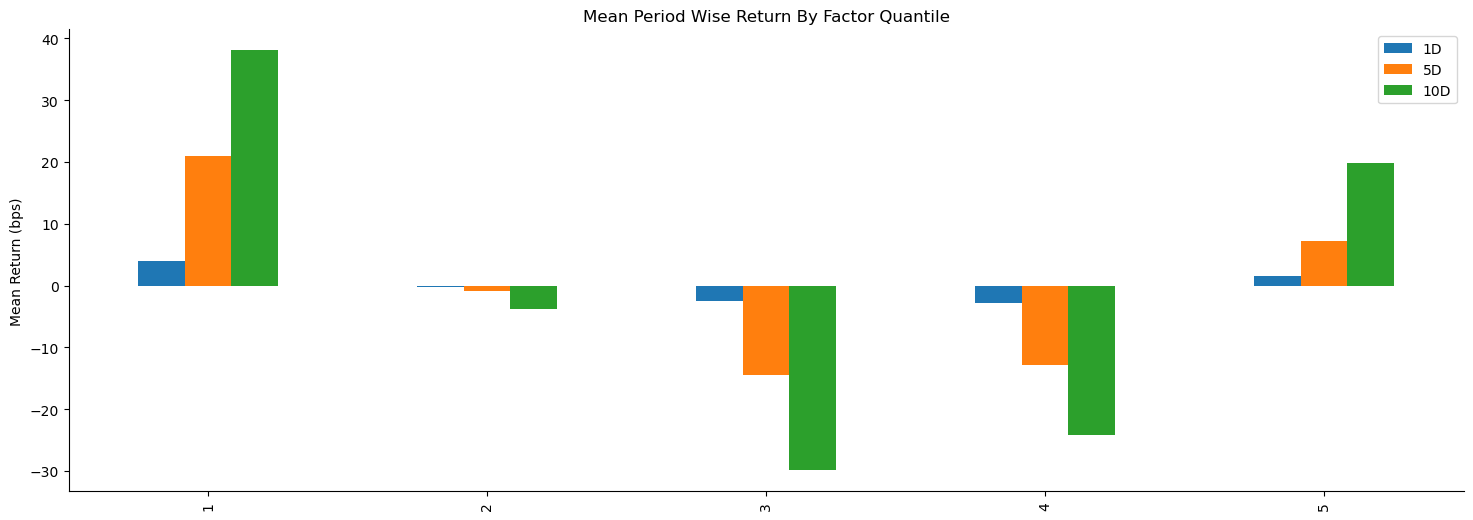

In [54]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_by_q)
sns.despine()

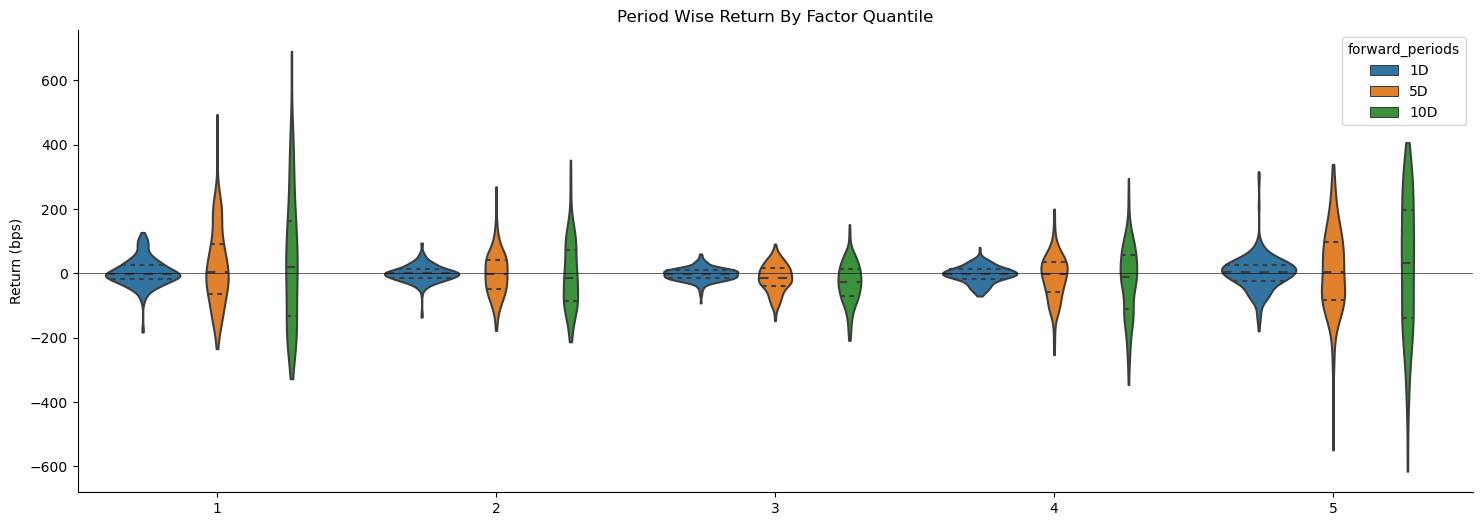

In [39]:
alphalens.plotting.plot_quantile_returns_violin(mean_return_by_q_daily)
sns.despine()

### 最高分位数和最低分位数头寸之间的日收益率差异

Top Minus Bottom Quantile Mean Return (1D Period Forward Return) 是Alphalens收益分析中的一种图表,用于展示因子最高分位数和最低分位数头寸之间的日收益率差异。

具体来说,这张图反映了如下计算结果:

1. 首先,每天按因子值大小将资产池分为若干分位数(quantile),通常是5分位数或10分位数。

2. 然后,计算最高分位数(Top)头寸和最低分位数(Bottom)头寸在当天及之后1日的平均收益率。

3. 图中的Y轴是Top分位数和Bottom分位数头寸收益率的差值。

4. 图的X轴是投资期限,这里设置为1日(1D Period Forward Return)。

这张图的意义在于直观展示了因子对收益率的区分能力:

- 如果因子有效,Top分位数头寸应当获得较高的正收益,Bottom分位数头寸应获得较低甚至为负的收益。

- 因此,Top-Bottom差值越大,说明因子的区分力度越强,对未来1日收益的预测能力越好。

- 差值围绕0则说明因子无法很好区分高低收益资产。

- 差值为负值时,则表明因子的预测方向与实际情况相反,需要修正或放弃该因子。

这个图有助于判断因子是否确实对未来1日内的收益有预测能力,是评估因子短期有效性的重要依据。通常差值越大、越显著偏离0越好,能够证明因子具备一定的选股区分能力和Alpha获取潜力。

In [40]:
quant_return_spread, std_err_spread = alphalens.performance.compute_mean_returns_spread(mean_return_by_q_daily,
                                                                                        upper_quant=5,
                                                                                        lower_quant=1,
                                                                                        std_err=std_err)

[<Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (1D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (5D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (10D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>]

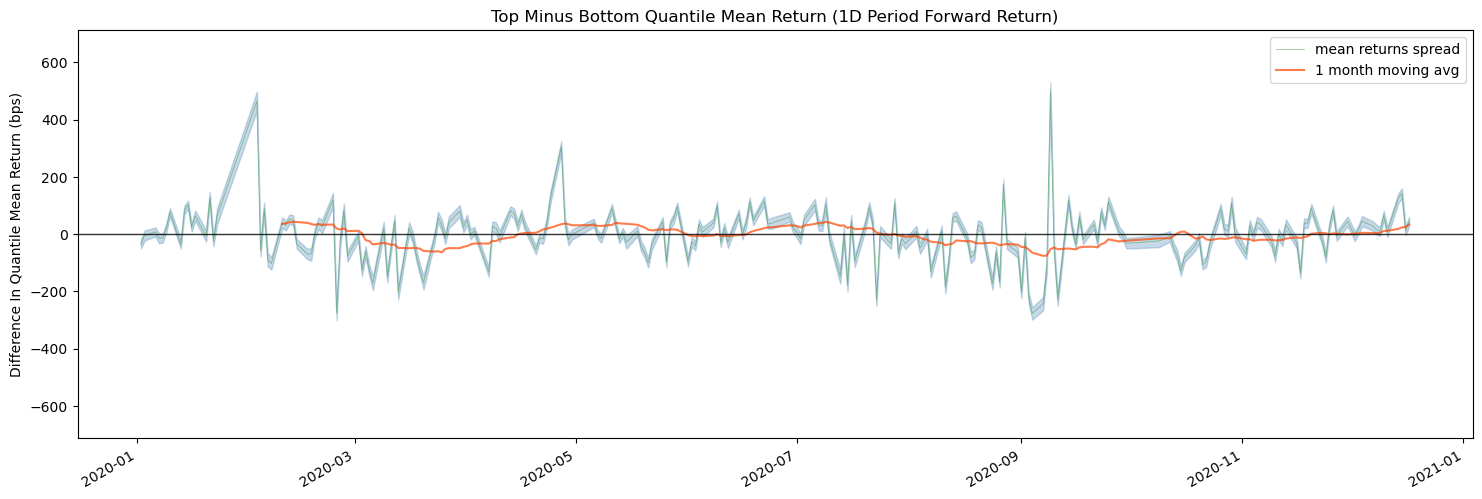

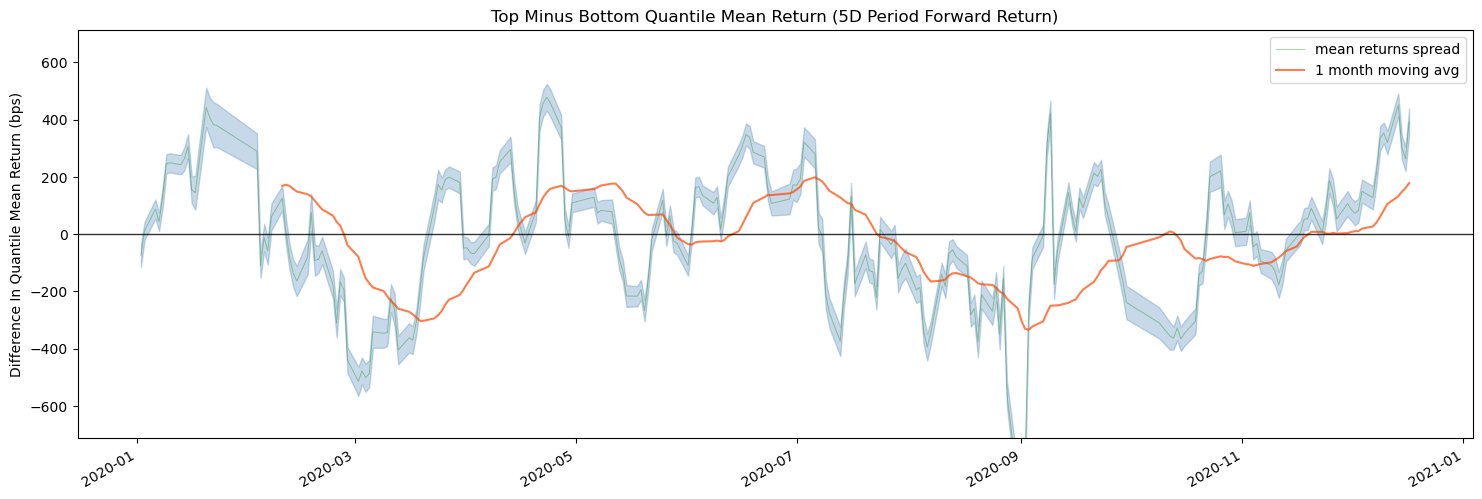

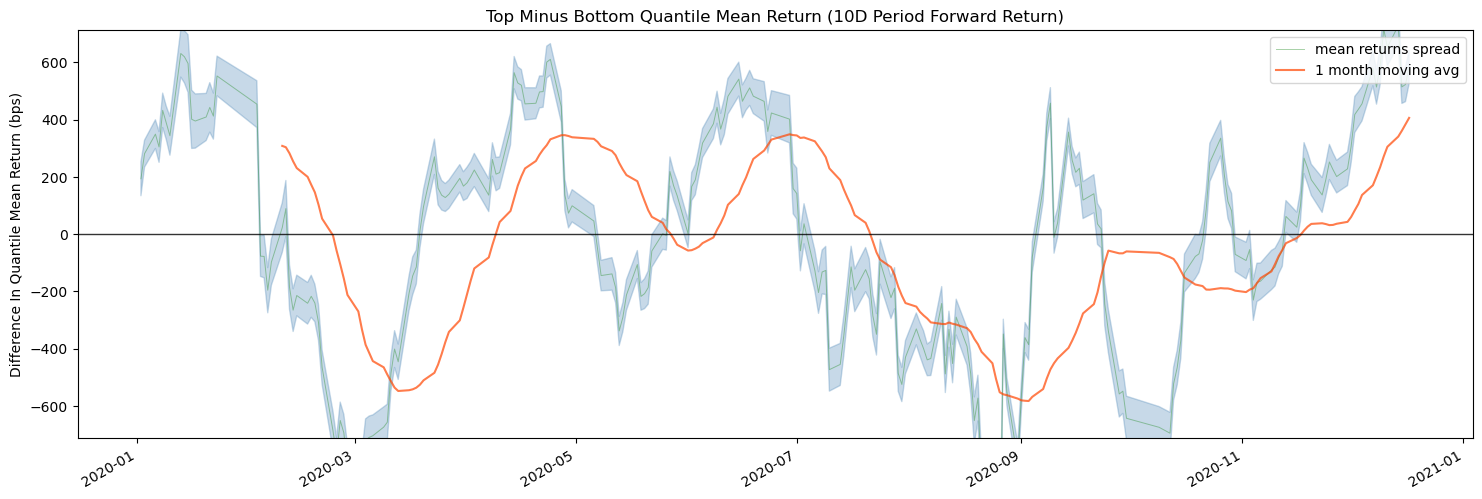

In [41]:
alphalens.plotting.plot_mean_quantile_returns_spread_time_series(
    quant_return_spread, std_err_spread)

### 累计收益情况

Cumulative Return by Quantile (1D Period Forward Return)是Alphalens收益分析中另一种常用的图表,它展示了按因子分位数分组后,不同分位数头寸在1日预测窗口内的累计收益情况。

具体来说,该图的绘制步骤如下:

1. 每天按因子值大小,将资产池分为若干分位数(quantile),比如5分位数或10分位数。

2. 对于每个分位数,构建相应的投资组合头寸(按因子值从高到低分别买入或卖空)。

3. 计算每个分位数头寸在当天及次日的简单收益率。

4. 在时间维度上,对各分位数头寸的日收益率进行计日累计,得到累计收益率序列。

5. 将这些累计收益率曲线按分位数分开绘制在同一张图上。

这种分位数累计收益图的意义在于:

1. 反映了因子对未来1日收益的预测能力强弱。如果高分位数和低分位数累计收益差异明显,说明因子具备一定选股/择时能力。

2. 曲线的走势一致性程度能反映因子的稳定性。如果高低分位数曲线高度一致,说明因子获利来源较为确定。

3. 在时间维度上,可观察不同时期因子表现的变化,判断是否具备持续性。

4. 高分位数曲线位于上方、低分位数曲线位于下方是理想状态,体现了因子的合理性。

5. 通过曲线的扇贝开口程度,可评估因子的潜在获利空间。

总的来说,这一图能够集中展示因子在未来1日预测窗口内的综合表现,从累计收益的角度审视因子的区分力度、持续性和稳定性,是评估因子短期有效性的重要视角。

C:\Users\Administrator\anaconda3\lib\site-packages\alphalens\plotting.py:852: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(1.0, linestyle="-", color="black", lw=1)


<Axes: title={'center': 'Cumulative Return by Quantile\n                    (1D Period Forward Return)'}, ylabel='Log Cumulative Returns'>

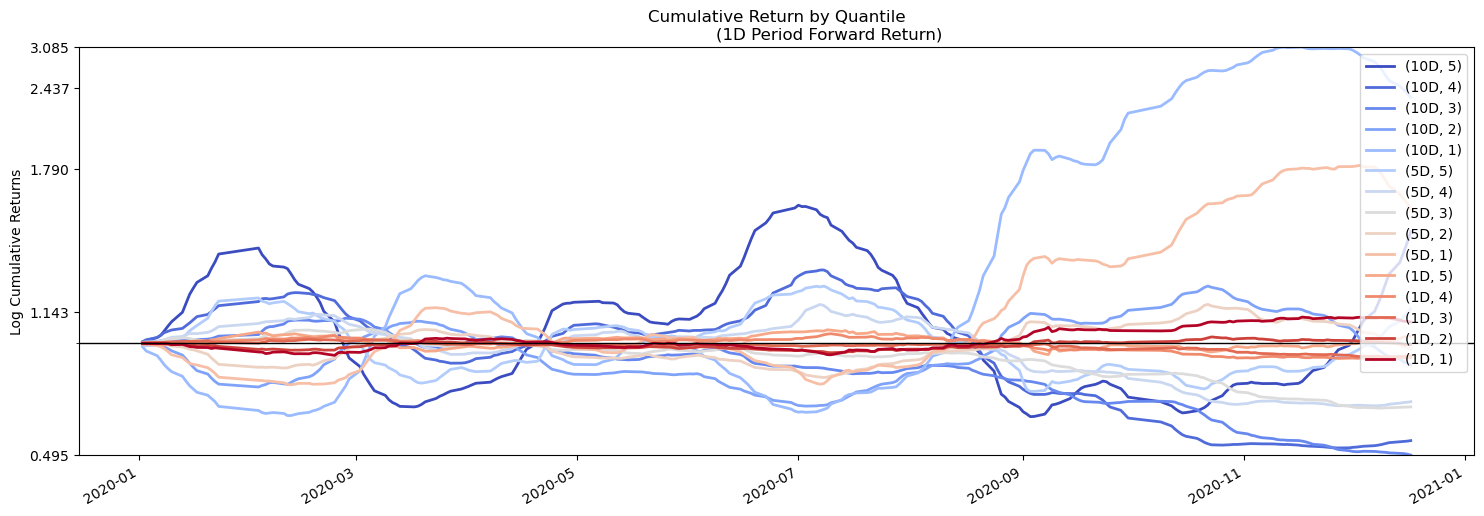

In [42]:
alphalens.plotting.plot_cumulative_returns_by_quantile(
    mean_return_by_q_daily, period='1D')

In [43]:
ls_factor_returns = alphalens.performance.factor_returns(factor_data)
ls_factor_returns.head()

,1D,5D,10D
date,,,
2020-01-02 00:00:00+00:00,-0.003426,-0.007422,-0.001467
2020-01-03 00:00:00+00:00,-0.004077,-0.002490,0.003963
2020-01-06 00:00:00+00:00,-0.001286,0.004330,0.009911
2020-01-07 00:00:00+00:00,0.001196,0.002946,0.007880
2020-01-08 00:00:00+00:00,0.000475,0.003554,0.012669


<Axes: title={'center': 'Portfolio Cumulative Return (1D Fwd Period)'}, ylabel='Cumulative Returns'>

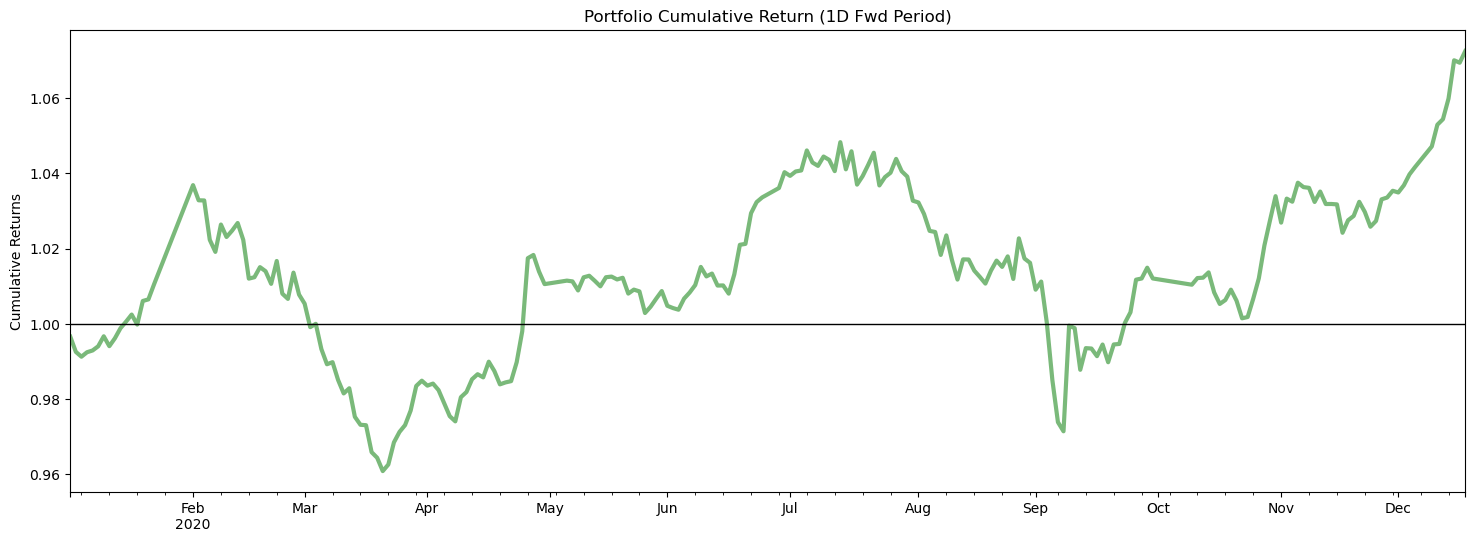

In [44]:
alphalens.plotting.plot_cumulative_returns(
    ls_factor_returns['1D'], period='1D')

In [45]:
alpha_beta = alphalens.performance.factor_alpha_beta(factor_data)
alpha_beta

,1D,5D,10D
Ann. alpha,0.101235,0.113491,0.124838
beta,-0.075235,-0.078454,-0.052082


### 一次性所有图

Returns Analysis


,1D,5D,10D
Ann. alpha,0.101,0.113,0.125
beta,-0.075,-0.078,-0.052
Mean Period Wise Return Top Quantile (bps),1.520,1.432,1.980
Mean Period Wise Return Bottom Quantile (bps),4.041,4.188,3.798
Mean Period Wise Spread (bps),-2.521,-2.783,-1.835


C:\Users\Administrator\anaconda3\lib\site-packages\alphalens\plotting.py:852: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(1.0, linestyle="-", color="black", lw=1)


<Figure size 640x480 with 0 Axes>

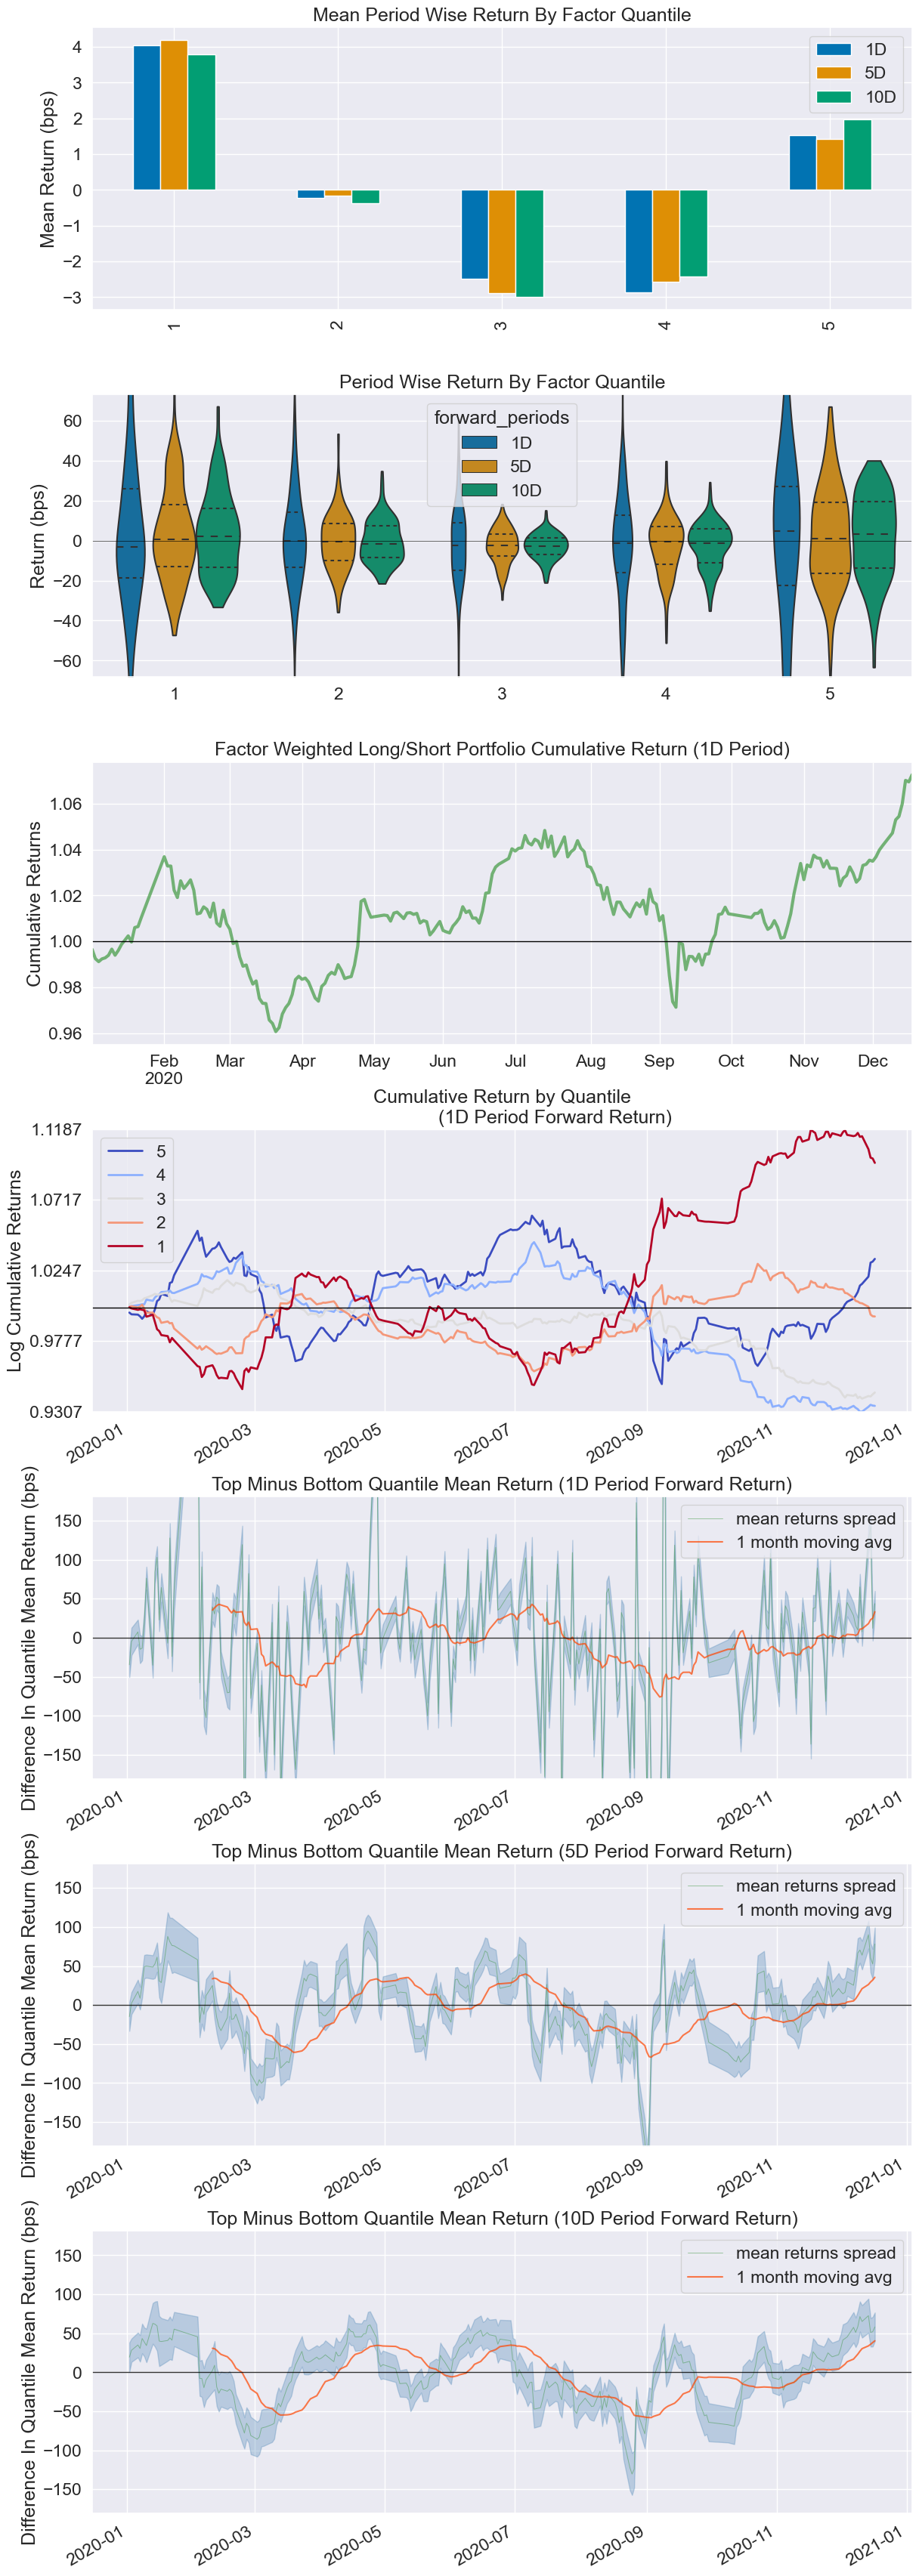

In [52]:
alphalens.tears.create_returns_tear_sheet(factor_data)

## 因子IC分析

信息分析是我们评估某个因素的预测价值而不受交易成本的混杂影响的一种方法。 我们看待这个问题的主要方法是通过信息系数（IC）。

信息系数 (IC) 是预测值优劣的衡量标准。 在金融领域，信息系数被用作金融分析师预测能力的绩效指标。 信息系数与相关性类似，可以看出它衡量两个随机变量之间的线性关系，例如 预测股票收益和实际收益。 信息系数的范围为0到1，0表示预测值与实际值之间没有线性关系（预测能力差），1表示完美的线性关系（预测能力好）。

IC值,全称为Information Coefficient,是衡量阿尔法因子预测能力的一个重要指标。

它的计算公式为:

IC = corr(因子值, 未来收益率)

即因子值与未来一段时间内资产的实际收益率之间的相关系数。

IC值的具体意义为:

1. 反映了因子对未来收益的预测方向和力度。
   - IC>0,说明因子能正确预测未来收益方向
   - IC值越大,预测力度越强

2. 衡量因子寻优(选股)和择时能力的有效性。
   - 好的选股因子,IC值应显著为正
   - 好的择时因子,IC在短期较高,长期衰减

3. 常被用于因子值与实际收益之间的显著性检验。
   - 检验IC值是否显著不同于0

4. 可以用于评估交易策略的有效性和盈利可能性。
   - 较高IC意味着策略有潜在Alpha获取能力

5. IC本身也可作为机器学习等模型训练的目标函数。
   - 优化模型以最大化IC值

总之,IC值综合衡量了因子的预测方向、力度和持续性,是评价和优化阿尔法因子不可或缺的关键指标之一。在Alphalens等因子库中,IC曲线分析是研究因子有效性的核心部分。

对于一个优秀的阿尔法因子,我们期望看到其IC值显著为正,且能在合理的投资持有期内保持在较高水平,然后平滑下降至0附近。

In [21]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
ic.head()

,1D,5D,10D
date,,,
2020-01-02 00:00:00+00:00,-0.086599,-0.055968,0.102489
2020-01-03 00:00:00+00:00,-0.035523,-0.000705,0.138504
2020-01-06 00:00:00+00:00,-0.037736,0.065379,0.153066
2020-01-07 00:00:00+00:00,-0.015618,0.028880,0.124890
2020-01-08 00:00:00+00:00,-0.047512,0.085507,0.161431


### 因子值与未来收益之间的相关性

Period Forward Return Information Coefficient (IC) 是Alphalens库中另一张重要的分析图表,用于展示不同预测窗口期限内,因子值与未来收益之间的相关性强弱。

具体来说,该图反映了以下指标的计算结果:

1. 信息系数IC(Information Coefficient)指标,定义为:
   IC = corr(factor_values, forward_returns)
   即因子值与预测窗口内未来收益率之间的相关系数。

2. 对于不同的预测窗口期限(如1日、1周、1月等),分别计算相应的IC值。

3. 将这些不同期限的IC值在同一张图上绘制出来,形成一条IC曲线。

这张IC曲线图的意义主要有:

1. 反映了因子对不同投资持有期限的预测效力。IC值越高(接近1),说明因子与未来收益相关性越强,预测能力越好。

2. 理想状态是IC值显著为正,且随投资期限的延长逐渐衰减为0。这说明因子确实具有选股择时能力,且其信号的有效期是有限的。

3. 如果IC值波动反复上下,或在较长期限内依然很高,可能意味着因子存在问题,如数据发烟问题（过度挖掘历史数据而导致的策略或因子表现被高估的现象）。

4. 将IC曲线与无信息分布(常数0线)做对比,可以判断因子的统计显著性水平。

5. 通过观察IC随期限变化的形态,可以确定因子信号的最佳持有期限范围。

6. 结合其他分析图表,有助于全面评估因子的实际应用价值和潜在风险。

总之,IC曲线能够很直观地展示因子对不同投资期限收益的预测力度变化,是验证因子有效性、分析其最佳持有期限的重要工具。通过与其他指标相结合,可以更全面地认识和利用一个阿尔法因子。

array([<Axes: title={'center': '1D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <Axes: title={'center': '5D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <Axes: title={'center': '10D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

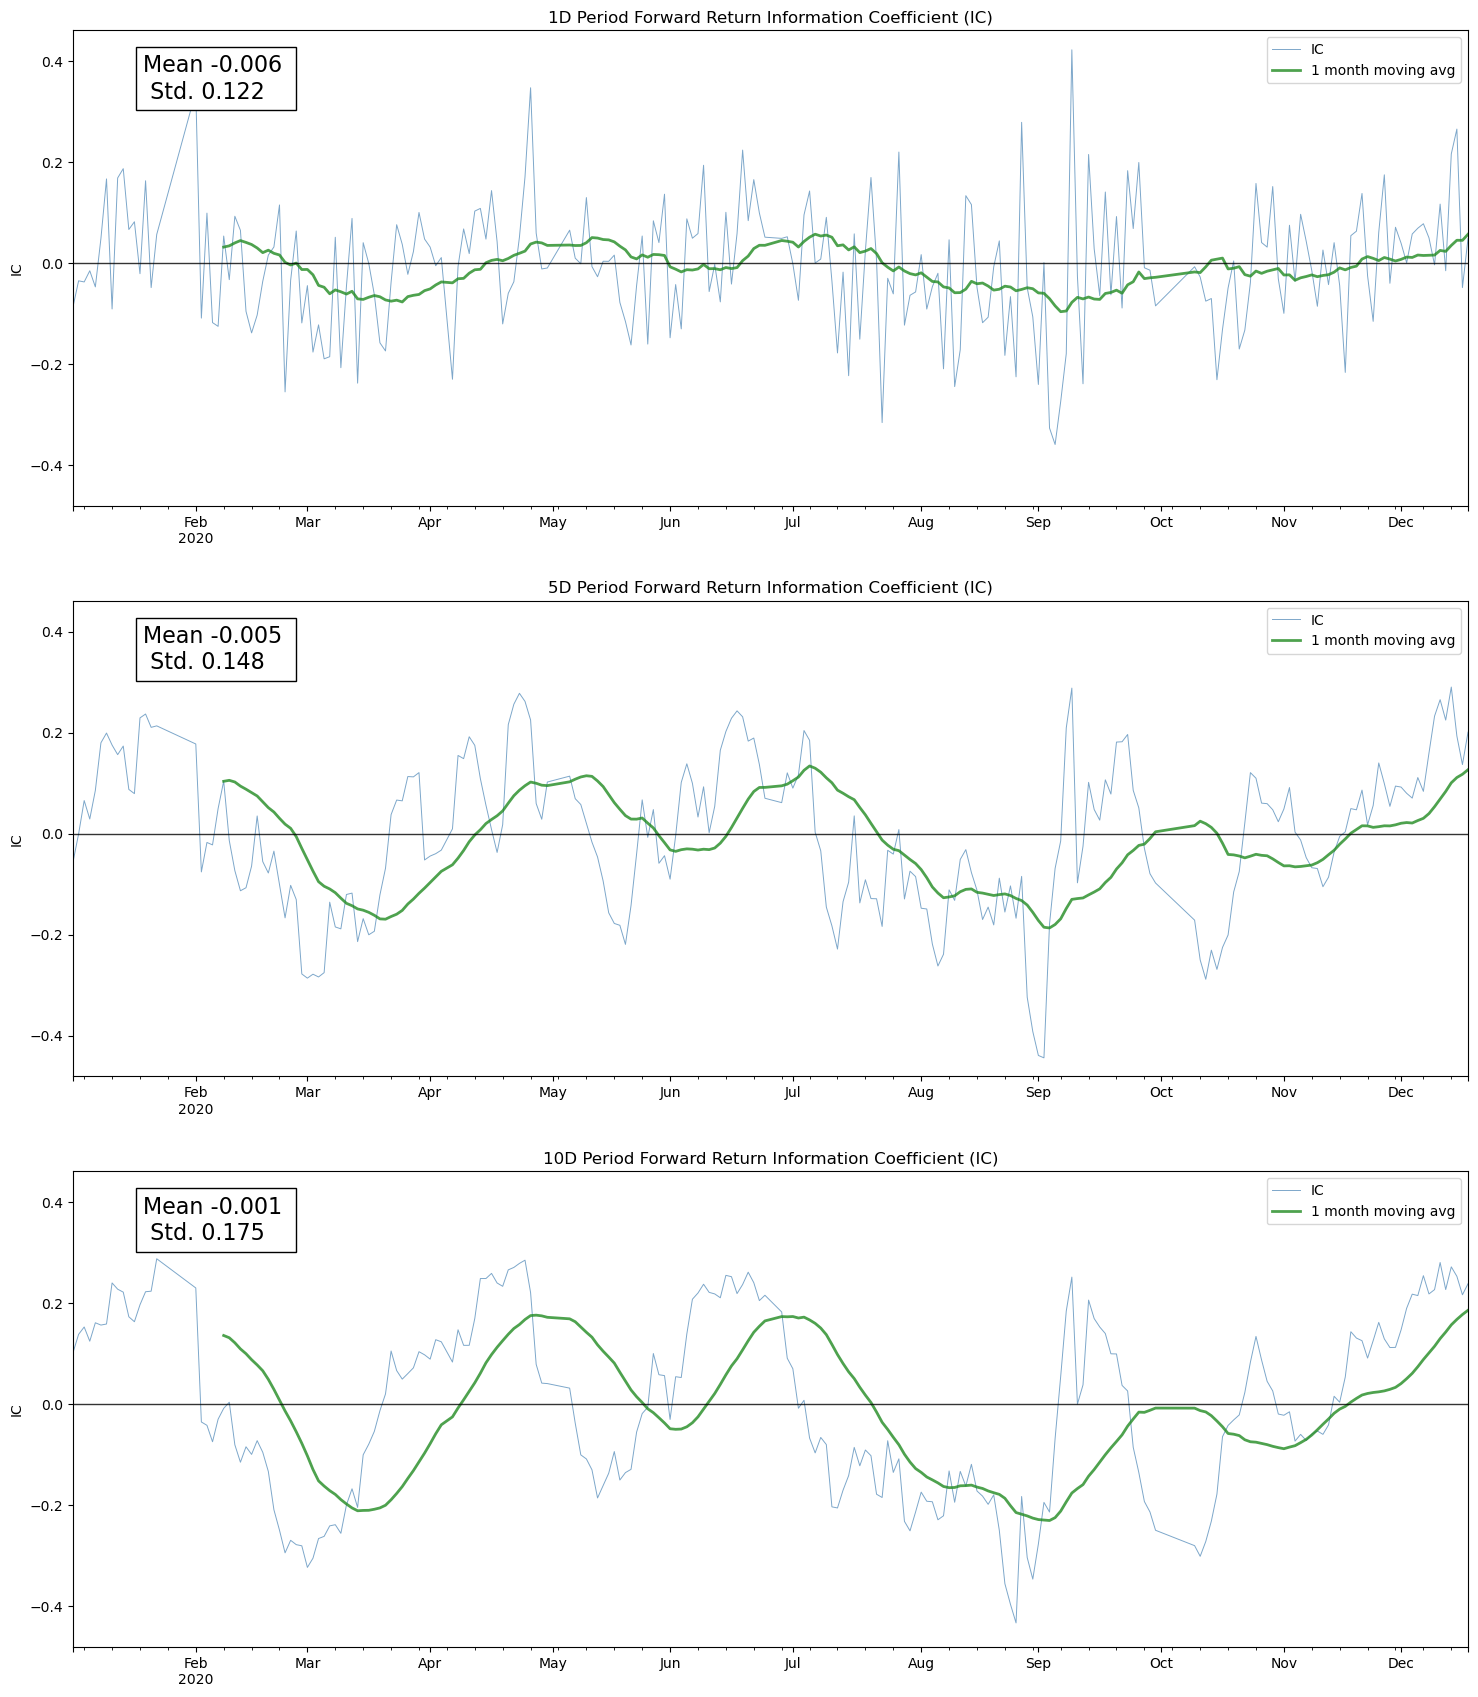

In [22]:
alphalens.plotting.plot_ic_ts(ic)

array([<Axes: title={'center': '1D Period IC'}, xlabel='IC', ylabel='Count'>,
       <Axes: title={'center': '5D Period IC'}, xlabel='IC', ylabel='Count'>,
       <Axes: title={'center': '10D Period IC'}, xlabel='IC', ylabel='Count'>],
      dtype=object)

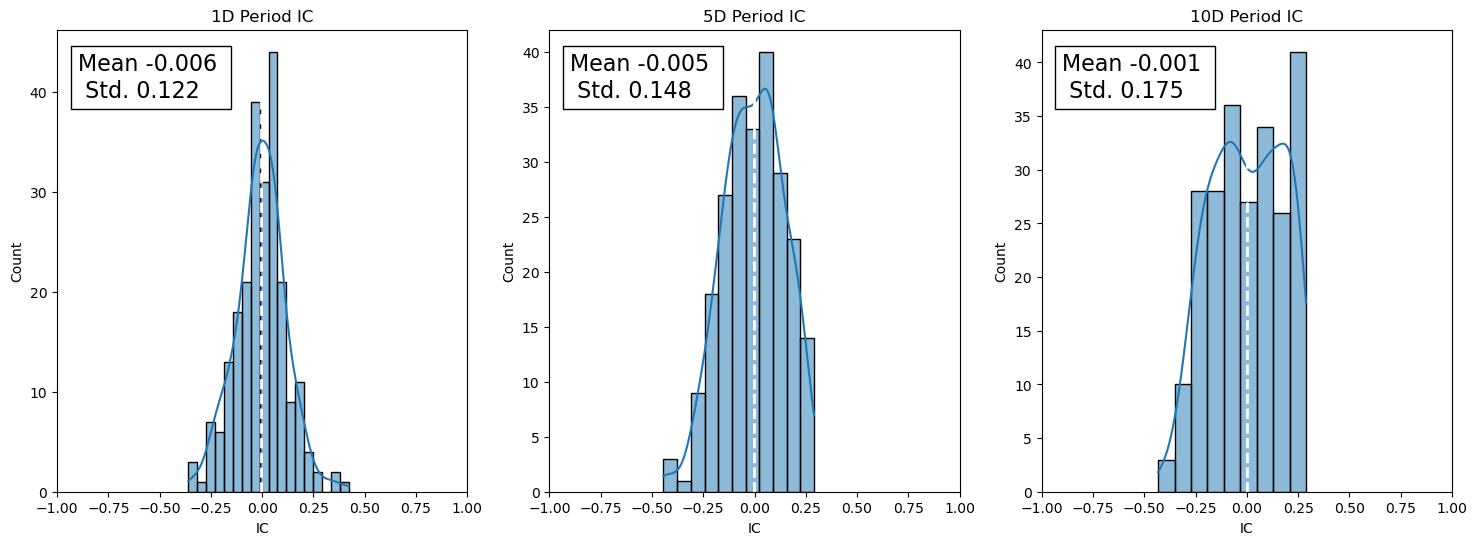

In [23]:
alphalens.plotting.plot_ic_hist(ic)

array([<Axes: title={'center': '1D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <Axes: title={'center': '5D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <Axes: title={'center': '10D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>],
      dtype=object)

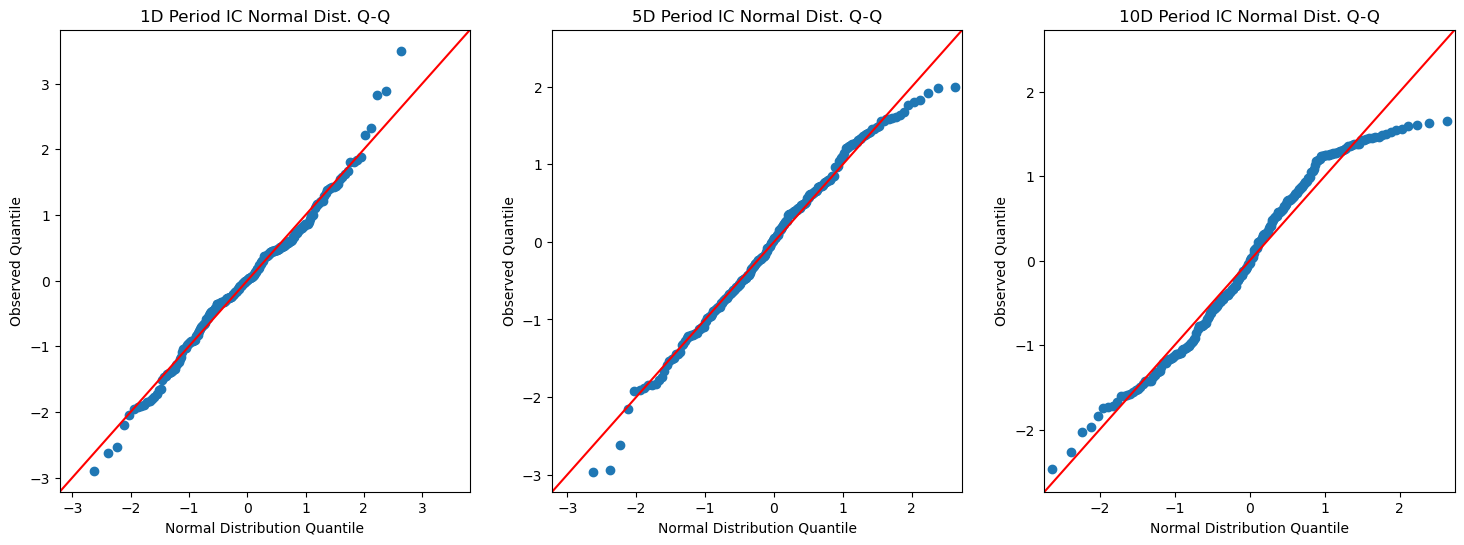

In [24]:
alphalens.plotting.plot_ic_qq(ic)

### 因子值与未来不同月度收益率之间的相关性

Monthly Mean Period IC 是Alphalens库中的一张分析图表,用于展示因子值与未来不同月度收益率之间的相关性(IC)均值。

这张图的具体生成过程是:

1. 将整个研究时间范围按月度划分
2. 对于每个月度:
    - 计算当月内每个交易日的日IC值(factor vs next day return)
    - 计算当月的平均日IC值,作为该月度的Mean Period IC
3. 将所有月度的Mean Period IC值按时间顺序绘制在一张图上

这张图的主要意义有:

1. 反映了因子对未来不同月度收益的平均预测能力
    - 月IC均值越高,说明该月份因子的预测力越强
    - 理想状态是月IC均值持续维持在较高正值

2. 展示了因子IC值的季节性特征
    - 可观察不同月份IC均值的波动情况
    - 有助于发现是否存在季节性规律

3. 评估因子IC均值随时间的变化趋势 
    - 持续上涨说明因子不断强化
    - 平稳则说明保持稳定预测力
    - 下降则需考虑因子生命周期

4. 与无信息分布(0线)对比,判断因子显著获胜水平
    - 稳定远离0线且正值,说明因子获胜显著可信

5. 结合其他分析图表,全面评估因子的长期获利能力

总的来说,这张图专注于分析因子在不同月度的平均预测水平及其变化趋势,有助于发现和利用因子的季节性特征,评判其长期持续获利能力,是研究因子生命周期的重要参考。

In [41]:
mean_monthly_ic = alphalens.performance.mean_information_coefficient(
    factor_data, by_time='M')
mean_monthly_ic.head()

,1D,5D,10D
date,,,
2020-01-31 00:00:00+00:00,0.027376,0.052605,0.051059
2020-02-29 00:00:00+00:00,0.026277,0.034399,0.030363
2020-03-31 00:00:00+00:00,-0.046434,-0.055457,-0.073183
2020-04-30 00:00:00+00:00,0.013856,0.010998,0.027248
2020-05-31 00:00:00+00:00,-0.006594,-0.004171,-0.024735


array([<Axes: title={'center': 'Monthly Mean 1D Period IC'}>,
       <Axes: title={'center': 'Monthly Mean 5D Period IC'}>,
       <Axes: title={'center': 'Monthly Mean 10D Period IC'}>],
      dtype=object)

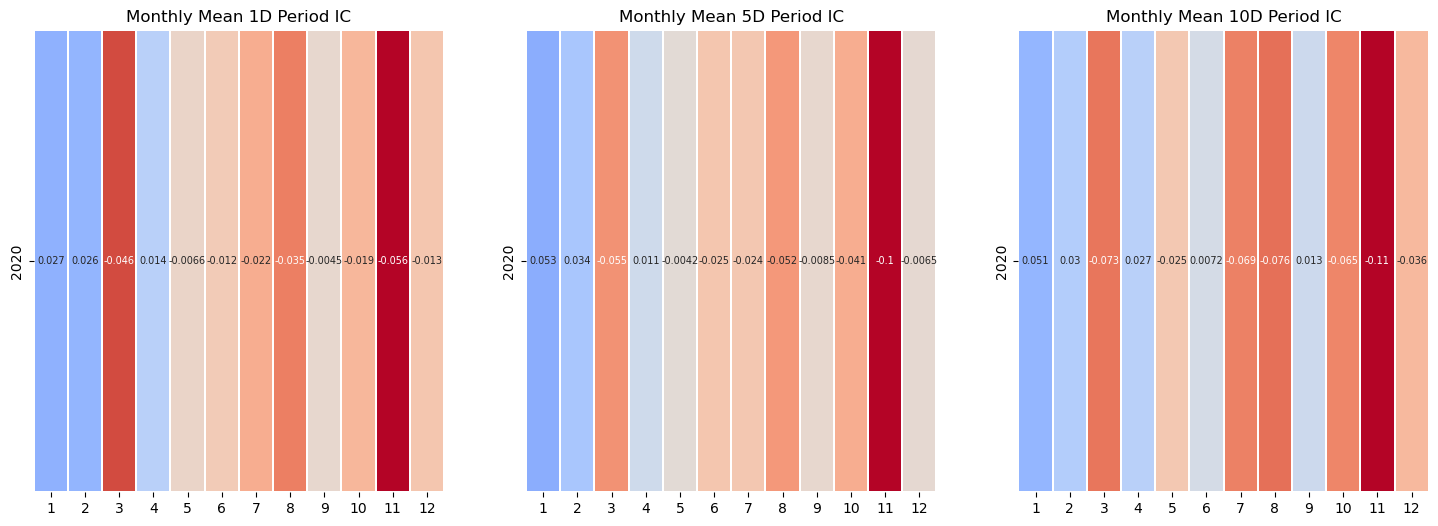

In [43]:
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)

### 一次性所有图

In [ ]:
# alphalens.tears.create_information_tear_sheet(factor_data)

## 换手率分析

Turnover Analysis是Alphalens库中针对投资组合换手率(Turnover)的一种分析方法。

投资组合换手率指的是一段时间内投资组合中被新增和剔除的证券的数量(或权重)占整个投资组合的比例。较高的换手率意味着投资组合的调整频率较高,交易成本和执行风险也会相应增加。

* 注意：Alphalens并不真实执行交易,而是根据因子值信号构建理论上的多空投资组合头寸。它只关注头寸本身的调整和资产权重的变化,而不涉及具体的订单挂撤和成交过程。因此,只要有股票的日级别价格数据,就可以计算出每日头寸内资产的权重变化,进而得到换手率指标,无需真实交易数据。


在因子研究和量化交易策略中,换手率分析有以下几个重要意义:

1. 评估因子头寸实施的难易程度
   - 换手率过高,说明因子头寸在执行层面存在挑战
   - 换手率合理则实施难度较小

2. 估计因子策略的交易成本和摩擦损失
   - 换手率高导致交易成本和市场冲击成本增加
   - 影响到策略的实际净收益水平

3. 确定因子信号的有效持有期
   - 低换手率暗示信号的持续性更强
   - 高换手率说明信号的有效期很短

4. 衡量因子头寸的稳定性
   - 理想状态下换手率应该相对平稳
   - 波动过大可能预示潜在的风险

在Turnover Analysis中,Alphalens通常会绘制换手率随时间变化的趋势图以及分布直方图,以供投资者判断和控制换手率水平。结合其他分析图表,可以综合考虑因子的预测力和实施难度,制定更加合理的交易策略。

总之,换手率分析是因子评估中不可或缺的一个重要环节,有助于权衡因子潜在收益和实施成本,优化最终的投资执行方案。

In [25]:
quantile_factor = factor_data['factor_quantile']
turnover_period = 1

In [26]:
quantile_turnover = pd.concat([alphalens.performance.quantile_turnover(quantile_factor, q, turnover_period)
                               for q in range(1, int(quantile_factor.max()) + 1)], axis=1)
quantile_turnover.head()

,1,2,3,4,5
date,,,,,
2020-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-01-03 00:00:00+00:00,0.020833,0.041775,0.033854,0.028721,0.015625
2020-01-06 00:00:00+00:00,0.018229,0.036554,0.044271,0.031332,0.005208
2020-01-07 00:00:00+00:00,0.018229,0.036554,0.046875,0.039164,0.010417
2020-01-08 00:00:00+00:00,0.026042,0.052219,0.046875,0.031332,0.010417


### 最高分位数和最低分位数头寸的换手率

1D Period Top and Bottom Quantile Turnover是Alphalens库中的一张分析图表,用于展示在1日预测期限内,根据因子构建的最高分位数(Top Quantile)头寸和最低分位数(Bottom Quantile)头寸的换手率情况。

具体来说,这张图反映了以下计算过程:

1. 每天将资产池按因子值从高到低排序,分成若干分位数(quantile),比如5分位或10分位。

2. 构建最高分位数多头头寸(Top)和最低分位数空头头寸(Bottom)。

3. 计算Top头寸和Bottom头寸在当天到次日这一日的换手率。即头寸中被新增和剔除的资产权重占比。

4. 将Top和Bottom头寸的日换手率值在图中分别绘制出来。

这张图的主要用途是:

1. 评估根据因子信号构建的投资头寸的换手率水平和变化趋势。

2. 较高的换手率意味着头寸调整频繁,交易成本较高,实施难度较大。

3. Top和Bottom头寸的换手率差异,反映了因子区分力强弱的一个侧面。

4. 随时间推移,对换手率趋势的观察有助于确定因子信号的最佳持有期限。

5. 结合其他分析图表,综合考虑因子的预测力和实施难度,制定最优化的投资策略。

总之,这张换手率图从投资组合的实际调整角度,量化地评估了根据因子构建头寸的操作复杂度,是全面评价一个阿尔法因子在真实投资场景下应用价值的重要参考。

<Axes: title={'center': '1D Period Top and Bottom Quantile Turnover'}, ylabel='Proportion Of Names New To Quantile'>

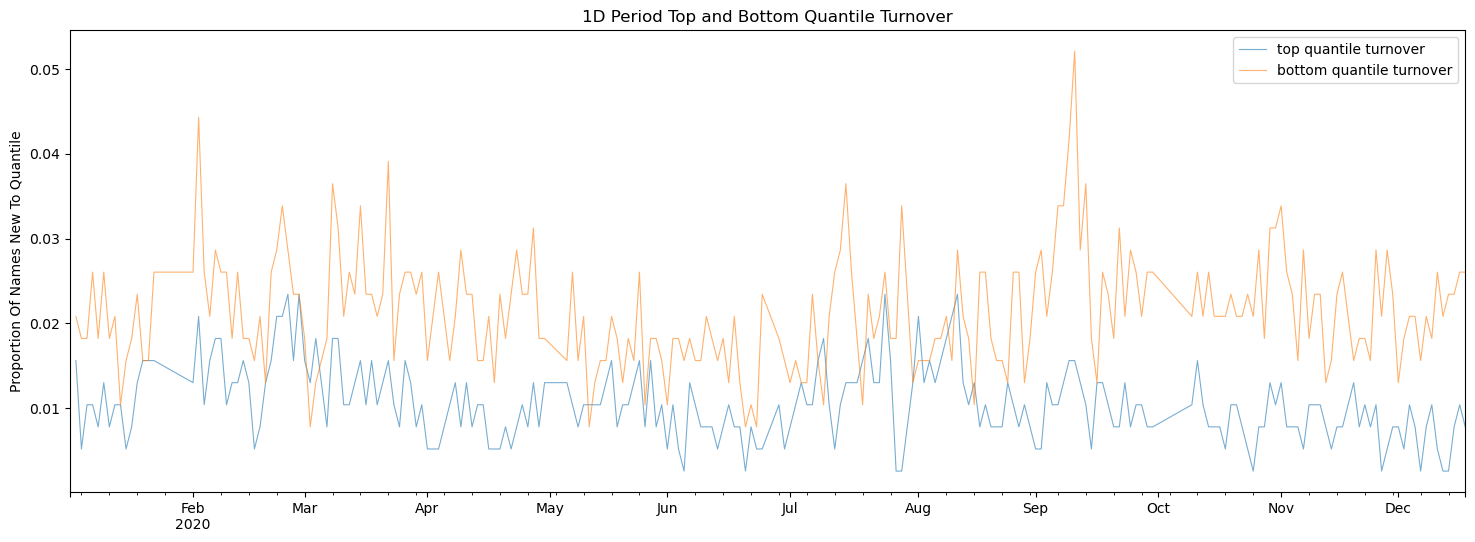

In [27]:
alphalens.plotting.plot_top_bottom_quantile_turnover(
    quantile_turnover, turnover_period)

### 因子值的自相关性

Period Factor Rank Autocorrelation是Alphalens库中换手率分析模块生成的一张重要图表,用于展示因子值的自相关性随时间变化的情况。

具体来说,这张图反映了以下计算过程:

1. 每天将资产池根据因子值从高到低排序,得到资产的排名。

2. 计算当天因子排名与之前几天(1日、5日、10日等)因子排名之间的相关系数(autocorrelation)。

3. 将这些不同滞后期(lag)下的自相关系数值在同一张图上绘制出来。

这张自相关性图的主要用途是:

1. 衡量因子值本身的持续性和稳定性。自相关系数越高,说明因子值的持续期越长。

2. 评估因子信号的有效持有期限。自相关性快速衰减意味着信号有效期较短。

3. 分析因子值随机变化的特征。如果自相关性长期维持在很高的水平,可能意味着数据存在"发烟"问题。

4. 与其他分析结果对比,综合判断因子信号的最优持有期和换手率水平。

5. 为制定投资策略的头寸调整频率提供参考依据。

总的来说,因子值的自相关性直接影响了基于该因子构建的投资组合需要多频繁地调整和重新平衡。通过这张图,可以全面分析因子值的变化规律,确定合理的换手率水平,从而更好地权衡收益和交易成本,优化最终的投资策略。

In [28]:
factor_autocorrelation = alphalens.performance.factor_rank_autocorrelation(
    factor_data, turnover_period)
factor_autocorrelation.head()

date
2020-01-02 00:00:00+00:00         NaN
2020-01-03 00:00:00+00:00    0.999513
2020-01-06 00:00:00+00:00    0.999416
2020-01-07 00:00:00+00:00    0.999520
2020-01-08 00:00:00+00:00    0.999324
Freq: C, Name: 1, dtype: float64

<Axes: title={'center': '1D Period Factor Rank Autocorrelation'}, ylabel='Autocorrelation Coefficient'>

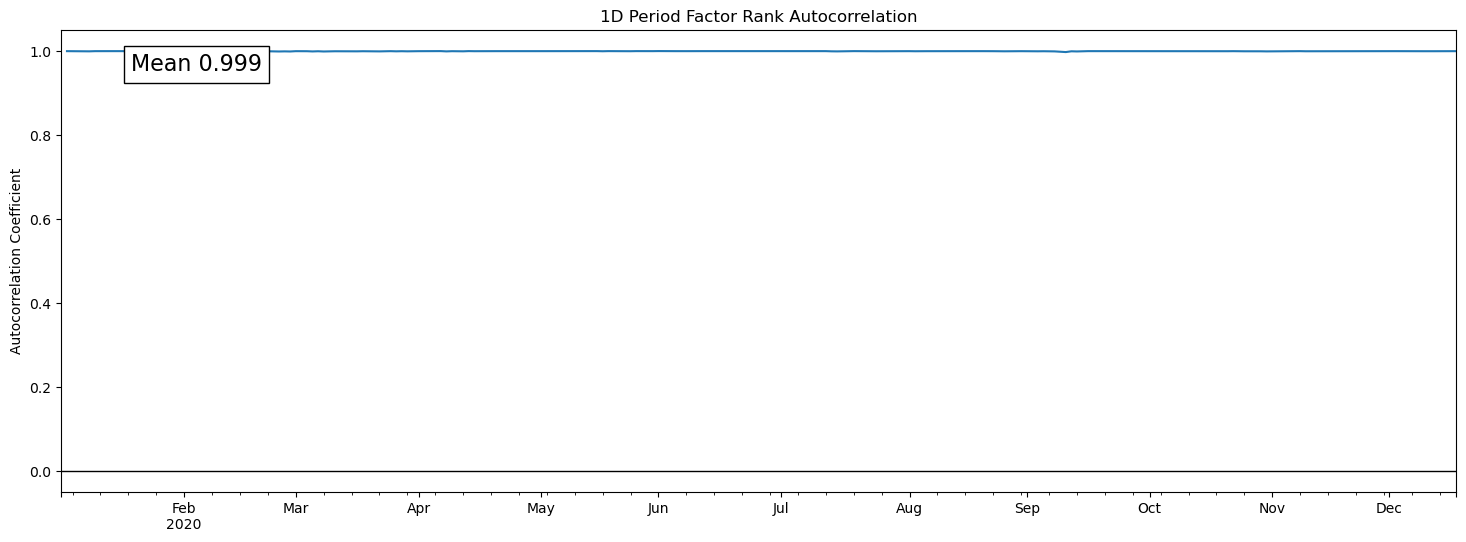

In [29]:
alphalens.plotting.plot_factor_rank_auto_correlation(factor_autocorrelation)

In [32]:
### 一次性所有图
#alphalens.tears.create_turnover_tear_sheet(factor_data)

## 事件分析

在Alphalens的事件研究分析中,"The Average Cumulative Return by Quantile"是一张非常有用的图表,用于展示在事件发生后的不同时间窗口内,按因子分位数分组后的平均累计收益情况。

具体来说,这张图的绘制过程如下:

1. 将整个研究时间范围内的交易日视为一个个"事件日"。

2. 对于每一个事件日,首先按当天的因子值将资产池分为多个分位数(quantile),比如5分位或10分位。

3. 计算每个分位数的资产组合在事件日及其后的一段时间内(如20日)的每日收益率。

4. 对每个分位数组合的日收益率进行计日累计,得到它们在事件日后的累计收益率序列。

5. 对上述所有事件日的累计收益率序列取平均值,形成最终的平均累计收益曲线。

6. 将不同分位数的平均累计收益曲线在同一张图中绘制出来。

这张图的主要用途是:

1. 判断因子的预测能力,观察不同分位数的收益差异。理想状态是高分位数收益曲线在上方,低分位数在下方。

2. 分析因子信号在事件后的有效持续期限。观察曲线开口程度和形状的变化。

3. 比较不同分位数收益曲线的形态差异,分析因子的稳健性和持续性。

4. 确定因子信号的最佳持有期限范围。曲线开口度最大时为最优持有期。

5. 结合其他事件分析图表,全面评估该因子在事件型投资策略中的潜在应用价值。

总之,这张图能够清晰展现一个因子在事件发生前后的获利能力和持续期限特征,是事件分析中最关键的指标之一,对于发掘和利用事件型阿尔法因子至关重要。

<Figure size 640x480 with 0 Axes>

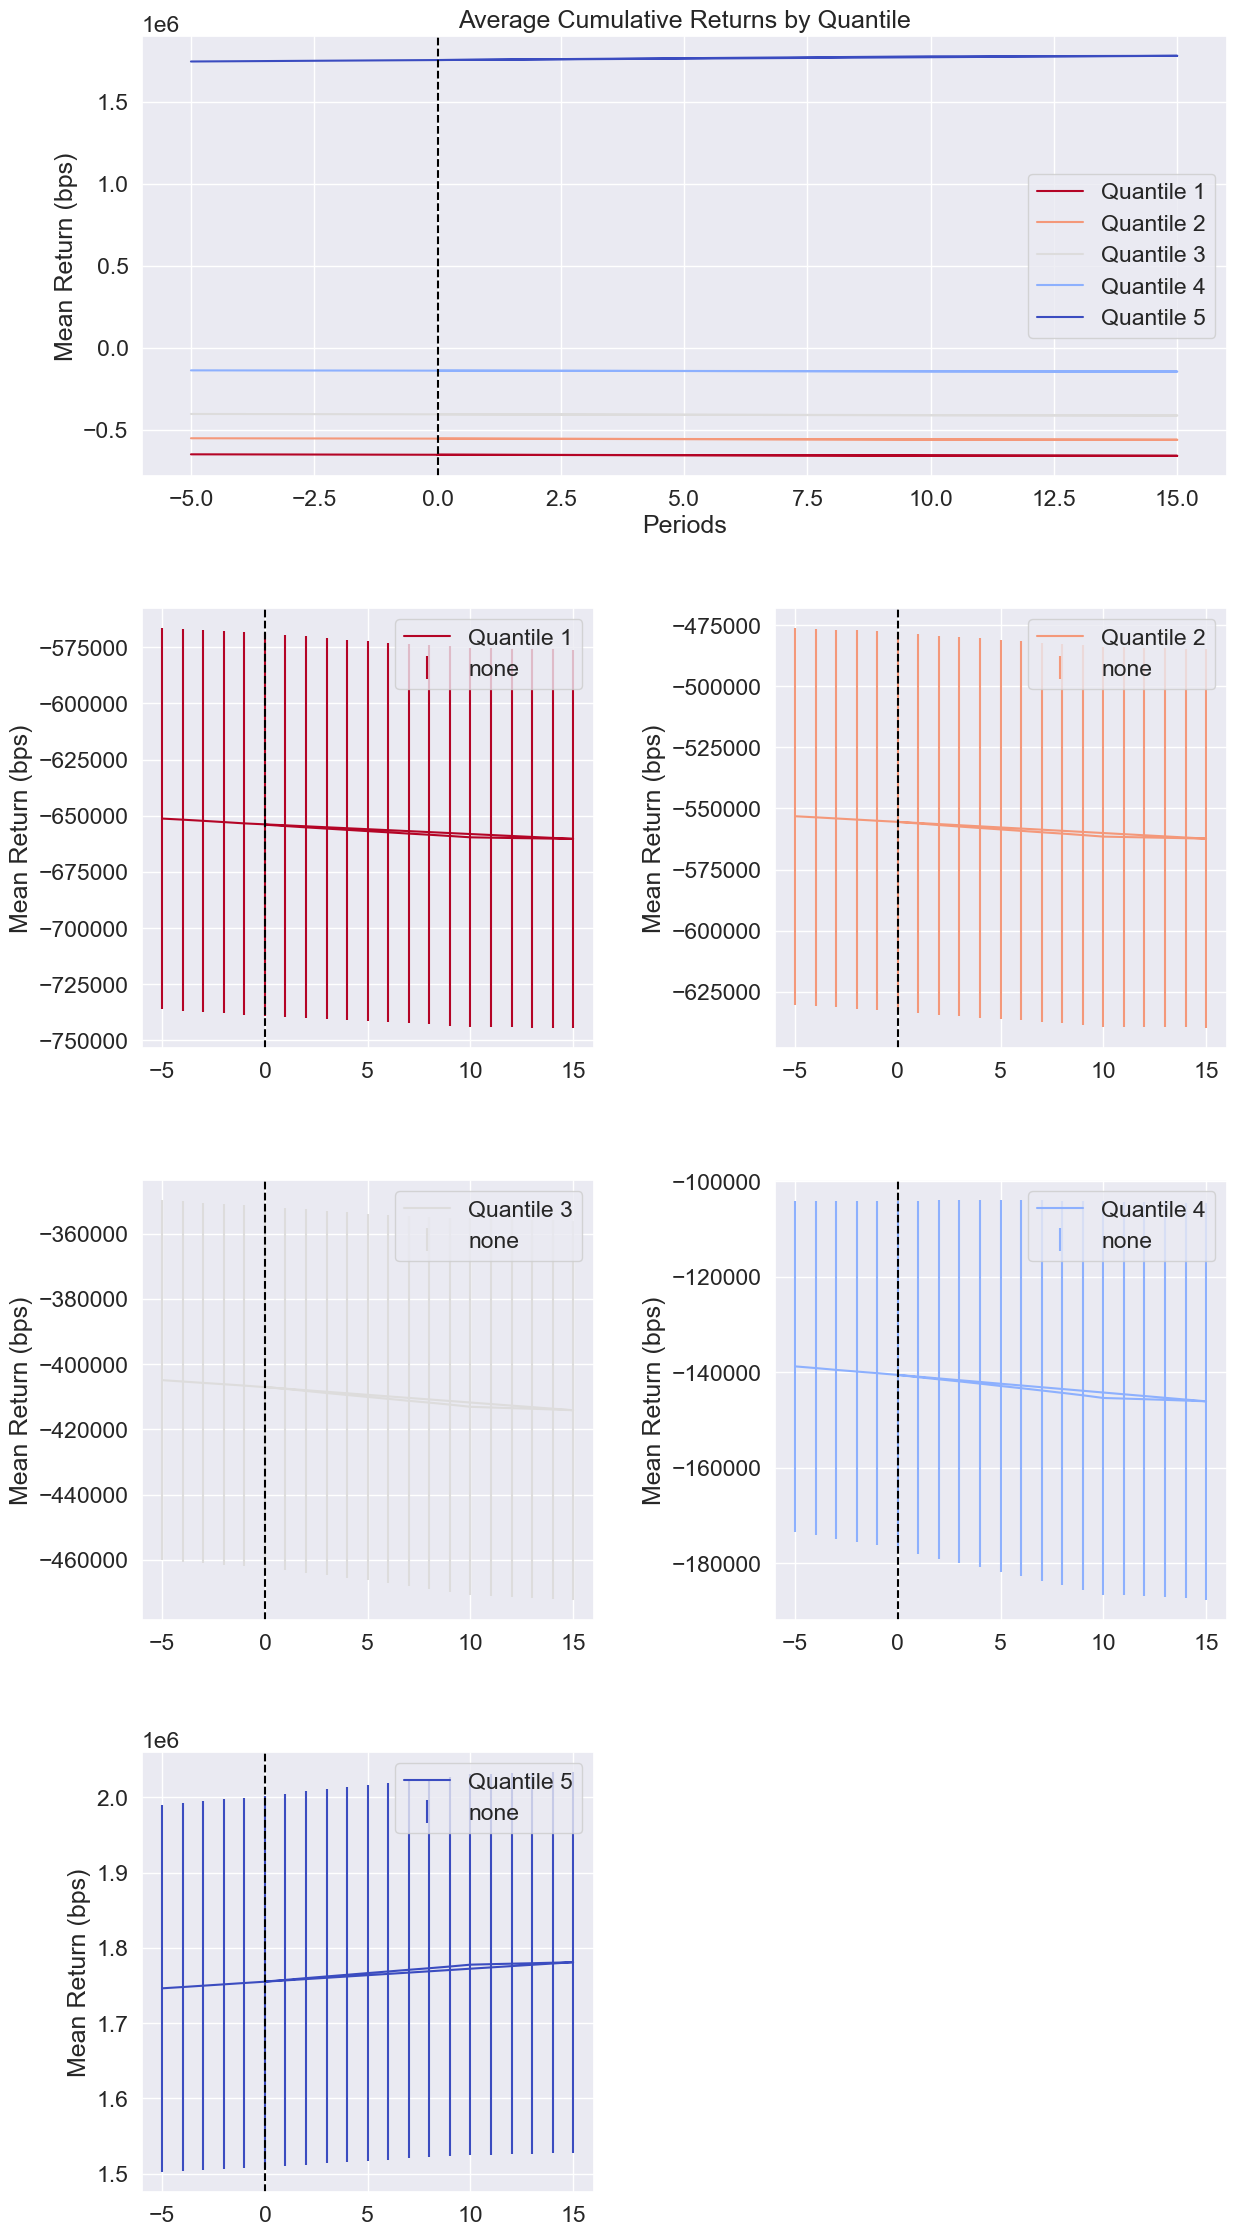

In [35]:
#注意这里没有股票行业信息因此无法做by-group=True
alphalens.tears.create_event_returns_tear_sheet(factor_data, stock_close)

## 分组绩效分析(Groupwise Performance)


Groupwise - 按群组/分组的方式,根据资产的某些属性(如行业、规模等)将资产池划分为若干非重叠的资产群组。

Performance - 指评估因子在构建投资组合后的表现,通常包括计算收益率、IC值、风险指标等。

所以Groupwise Performance的准确含义是:对不同资产群组内分别评估因子的投资表现,包括收益率、IC值等指标的计算和分析。

这种分组分析方式的主要目的,是探究同一因子在不同类型资产群组中是否存在显著的表现差异,从而判断该因子是否具有一定的偏差或局限性。

如果一个因子在大多数资产群组中都表现良好且一致,那它就被认为是一个稳健且值得信赖的因子。反之,如果它在某些特定群组中表现亮眼,但在其他群组中却失利,那就可能意味着这个因子存在一些固有的偏差和缺陷。

因此,Groupwise Performance分析为我们从另一个侧面全面评估和诊断了因子的有效性和可靠程度,是阿尔法因子研究过程中一个重要的补充和延伸内容。

Alphalens库中的Groupwise Performance分析是针对不同资产组别评估因子表现的一种重要方法。它的实施过程和主要意义如下:

实施过程:

1. 资产分组
   - 根据资产的元数据(如行业、规模、波动率等),将资产池划分为多个非重叠的资产组别(groups)。
   - 常见的分组方式有行业分类、市值分类等。

2. 计算组内因子收益
   - 对于每个资产组别,计算基于该因子构建的投资组合在该组内的日收益率。
   - 这相当于只考虑同一组别内的资产,评估因子对这类资产的表现。

3. 收益分析与可视化
   - 针对每个组别的因子收益,分别计算累计收益率、年化收益率、IC值等指标。
   - 通过绘制分析图表(如收益扇贝图、IC曲线图等),展示每个组别内的因子表现。

4. 组间对比
   - 将不同组别内的因子表现指标并列对比,观察它们之间的差异。
   - 通过对比,识别因子在哪些资产类型上表现最佳,哪些类型较差。

主要意义:

1. 发现因子在某些特定资产类型上的有效性
   - 有些因子对不同类型资产的适用效果差异很大。组别分析可以发现这些差异。

2. 识别因子存在的潜在偏差
   - 如果某因子在某些行业/规模/风格等组别内表现极佳,在其他组别内却很差,可能存在偏差。
   - 通过分析这种偏差,可以优化和完善因子的构造方法。 

3. 制定分层投资策略
   - 对于在某些组别内表现优异的因子,可针对这些组别制定专门的投资策略和头寸配置方案。

4. 控制投资组合的风险暴露
   - 通过组别分析,可以识别出因子可能带来的行业/风格等暴露,从而控制投资组合的风险。  

5. 全面评估因子的可靠性和稳健性
   - 如果某因子在大多数组别内都表现良好且一致,说明其稳健性较强,可靠程度较高。


总之,Groupwise Performance分析有助于更加细致、多角度地评估阿尔法因子在不同市场环境和资产条件下的表现,发现其优缺点和潜在风险,为制定可靠的投资策略提供重要的分析工具。